# NLP501 - Session 03: Vector Space Models
# Lab Practice: Word Vectors, TF-IDF, Cosine Similarity & PCA

In [29]:
# !pip install numpy pandas matplotlib scikit-learn nltk

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import math
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, TruncatedSVD

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_colwidth', 100)
np.set_printoptions(precision=4, suppress=True)


## Part 1: Data preparation

In [31]:
# Corpus 
corpus = [
    "Machine learning is a subset of artificial intelligence that enables computers to learn from data.",
    "Deep learning uses neural networks with many layers to model complex patterns in data.",
    "Natural language processing helps computers understand and generate human language.",
    "Neural networks are inspired by the biological structure of the human brain.",
    "Supervised learning requires labeled training data to make predictions.",
    "Unsupervised learning finds hidden patterns in data without labeled examples.",
    "Text classification is a common natural language processing task.",
    "Word embeddings represent words as dense vectors in a continuous space.",
    "Recurrent neural networks are designed for sequential data like text and time series.",
    "Transformers have revolutionized natural language processing with attention mechanisms."
]

# Document titles for reference
doc_titles = [
    "D1: ML Introduction",
    "D2: Deep Learning",
    "D3: NLP Overview",
    "D4: Neural Networks",
    "D5: Supervised Learning",
    "D6: Unsupervised Learning",
    "D7: Text Classification",
    "D8: Word Embeddings",
    "D9: RNN",
    "D10: Transformers"
]

print(f" Corpus includes {len(corpus)} documents:\n")
for i, (title, doc) in enumerate(zip(doc_titles, corpus)):
    print(f"{title}: {doc[:60]}...")

 Corpus includes 10 documents:

D1: ML Introduction: Machine learning is a subset of artificial intelligence that...
D2: Deep Learning: Deep learning uses neural networks with many layers to model...
D3: NLP Overview: Natural language processing helps computers understand and g...
D4: Neural Networks: Neural networks are inspired by the biological structure of ...
D5: Supervised Learning: Supervised learning requires labeled training data to make p...
D6: Unsupervised Learning: Unsupervised learning finds hidden patterns in data without ...
D7: Text Classification: Text classification is a common natural language processing ...
D8: Word Embeddings: Word embeddings represent words as dense vectors in a contin...
D9: RNN: Recurrent neural networks are designed for sequential data l...
D10: Transformers: Transformers have revolutionized natural language processing...


### 1.1 Text Preprocessing

In [32]:
def preprocess_text(text, remove_stopwords=True):
    """
    Text preprocessing:
    1. Lowercase
    2. Remove punctuation
    3. Tokenize
    4. Remove stopwords (optional)
    
    Args:
        text: Input text
        remove_stopwords: Whether to remove stopwords
    
    Returns:
        List of processed tokens
    """
    text = text.lower()
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    tokens = word_tokenize(text)
    
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [t for t in tokens if t not in stop_words]
    
    return tokens

# Test
sample = corpus[0]
print(f"Original: {sample}")
print(f"\nProcessed: {preprocess_text(sample)}")

Original: Machine learning is a subset of artificial intelligence that enables computers to learn from data.

Processed: ['machine', 'learning', 'subset', 'artificial', 'intelligence', 'enables', 'computers', 'learn', 'data']


In [33]:
processed_corpus = [preprocess_text(doc) for doc in corpus]

# Build vocabulary
all_words = [word for doc in processed_corpus for word in doc]
vocabulary = sorted(set(all_words))

print(f" Corpus statistics:")
print(f"   - Total tokens: {len(all_words)}")
print(f"   - Vocabulary size: {len(vocabulary)}")
print(f"\n Vocabulary: {vocabulary[:30]}") # print first 30 words

 Corpus statistics:
   - Total tokens: 85
   - Vocabulary size: 62

 Vocabulary: ['artificial', 'attention', 'biological', 'brain', 'classification', 'common', 'complex', 'computers', 'continuous', 'data', 'deep', 'dense', 'designed', 'embeddings', 'enables', 'examples', 'finds', 'generate', 'helps', 'hidden', 'human', 'inspired', 'intelligence', 'labeled', 'language', 'layers', 'learn', 'learning', 'like', 'machine']


## Part 2: Term-Document Matrix

### Exercise 2.1: Build Term-Document Matrix

In [34]:
def build_term_document_matrix(processed_docs, vocab):
    """
    Build Term-Document Matrix.
    """
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    matrix = np.zeros((len(vocab), len(processed_docs)))
    
    for doc_idx, doc in enumerate(processed_docs):
        word_counts = Counter(doc)
        for word, count in word_counts.items():
            if word in word_to_idx:
                matrix[word_to_idx[word], doc_idx] = count
    
    return matrix

td_matrix = build_term_document_matrix(processed_corpus, vocabulary)
print(f" Term-Document Matrix shape: {td_matrix.shape}")
print(f"   - {td_matrix.shape[0]} terms (vocabulary)")
print(f"   - {td_matrix.shape[1]} documents")

 Term-Document Matrix shape: (62, 10)
   - 62 terms (vocabulary)
   - 10 documents


In [35]:
sample_words = ['learning', 'neural', 'networks', 'data', 'language', 'natural']
sample_indices = [vocabulary.index(w) for w in sample_words if w in vocabulary]

df_td = pd.DataFrame(
    td_matrix[sample_indices, :],
    index=[vocabulary[i] for i in sample_indices],
    columns=[f"D{i+1}" for i in range(len(corpus))]
)

print(" Sample Term-Document Matrix:")
display(df_td.astype(int))

 Sample Term-Document Matrix:


,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
learning,1,1,0,0,1,1,0,0,0,0
neural,0,1,0,1,0,0,0,0,1,0
networks,0,1,0,1,0,0,0,0,1,0
data,1,1,0,0,1,1,0,0,1,0
language,0,0,2,0,0,0,1,0,0,1
natural,0,0,1,0,0,0,1,0,0,1


###  Analyzing: Word Vectors from Term-Document Matrix

Each row is a word vector
Each column is a document vector

In [36]:
# Get word vector for the word "learning"
learning_idx = vocabulary.index('learning')
learning_vector = td_matrix[learning_idx, :]

print(f" Word vector for 'learning':")
print(f"   Vector: {learning_vector}")
print(f"   Shape: {learning_vector.shape}")
print(f"\n   Appears in: ", end="")
for i, count in enumerate(learning_vector):
    if count > 0:
        print(f"D{i+1}({int(count)}x) ", end="")

 Word vector for 'learning':
   Vector: [1. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
   Shape: (10,)

   Appears in: D1(1x) D2(1x) D5(1x) D6(1x) 

##  Part 3: Word-Word Co-occurrence Matrix

Buid Co-occurrence matrix for word-word with contex window

### ️ Exercise 3.1: Build Word-Word Matrix

In [37]:
def build_cooccurrence_matrix(processed_docs, vocab, window_size=2):
    """
    Build Word-Word Co-occurrence Matrix.
    """
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    matrix = np.zeros((len(vocab), len(vocab)))
    
    for doc in processed_docs:
        for i, word in enumerate(doc):
            if word not in word_to_idx:
                continue
            word_idx = word_to_idx[word]
            
            # Context window
            start = max(0, i - window_size)
            end = min(len(doc), i + window_size + 1)
            
            for j in range(start, end):
                if i != j and doc[j] in word_to_idx:
                    context_idx = word_to_idx[doc[j]]
                    matrix[word_idx, context_idx] += 1
    
    return matrix

# Build matrix with window_size = 2
cooc_matrix = build_cooccurrence_matrix(processed_corpus, vocabulary, window_size=2)
print(f" Co-occurrence Matrix shape: {cooc_matrix.shape}")

 Co-occurrence Matrix shape: (62, 62)


In [38]:
# Display some words
focus_words = ['neural', 'networks', 'learning', 'deep', 'language', 'natural']
focus_indices = [vocabulary.index(w) for w in focus_words if w in vocabulary]

df_cooc = pd.DataFrame(
    cooc_matrix[np.ix_(focus_indices, focus_indices)],
    index=[vocabulary[i] for i in focus_indices],
    columns=[vocabulary[i] for i in focus_indices]
)

print(" Co-occurrence Matrix (sample):")
display(df_cooc.astype(int))

 Co-occurrence Matrix (sample):


,neural,networks,learning,deep,language,natural
neural,0,3,1,0,0,0
networks,3,0,0,0,0,0
learning,1,0,0,1,0,0
deep,0,0,1,0,0,0
language,0,0,0,0,0,3
natural,0,0,0,0,3,0


### Analyzing: Comparing different window size

In [39]:
# Compare with different window sizes
window_sizes = [1, 2, 3, 5]

print(" Let check the impact of Window Size on the co-occurrence of 'neural' and 'networks':")

neural_idx = vocabulary.index('neural')
networks_idx = vocabulary.index('networks')

for ws in window_sizes:
    matrix = build_cooccurrence_matrix(processed_corpus, vocabulary, window_size=ws)
    count = matrix[neural_idx, networks_idx]
    print(f"   Window size = {ws}: co-occurrence count = {int(count)}")

 Let check the impact of Window Size on the co-occurrence of 'neural' and 'networks':
   Window size = 1: co-occurrence count = 3
   Window size = 2: co-occurrence count = 3
   Window size = 3: co-occurrence count = 3
   Window size = 5: co-occurrence count = 3


## Part 4: TF-IDF Implementation

### ️ Exercise 4.1: Implementing TF-IDF

In [40]:
def compute_tf(doc):
    """ Calculating Term Frequency (log-normalized)."""
    word_counts = Counter(doc)
    tf = {}
    for word, count in word_counts.items():
        tf[word] = 1 + math.log10(count) if count > 0 else 0
    return tf


def compute_idf(processed_docs):
    """ Calculating Inverse Document Frequency (IDF) for the corpus."""
    N = len(processed_docs)
    
    # Count document frequency
    df = Counter()
    for doc in processed_docs:
        unique_words = set(doc)
        for word in unique_words:
            df[word] += 1
    
    # Calculate IDF
    idf = {word: math.log10(N / count) for word, count in df.items()}
    return idf


def compute_tfidf(doc, idf_dict, vocab):
    """Calculating TF-IDF vector."""
    tf = compute_tf(doc)
    
    tfidf_vector = np.zeros(len(vocab))
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    
    for word in doc:
        if word in word_to_idx and word in idf_dict:
            idx = word_to_idx[word]
            tfidf_vector[idx] = tf[word] * idf_dict[word]
    
    return tfidf_vector


# Calculate IDF for corpus
idf_dict = compute_idf(processed_corpus)

# Calculate TF-IDF for all documents
tfidf_matrix_scratch = np.array([
    compute_tfidf(doc, idf_dict, vocabulary) 
    for doc in processed_corpus
])

print(f" TF-IDF Matrix shape: {tfidf_matrix_scratch.shape}")

 TF-IDF Matrix shape: (10, 62)


In [41]:
# Display some IDF values
sample_idf_words = ['learning', 'neural', 'networks', 'data', 'natural', 'language', 'deep']

print(" IDF Values:")
for word in sample_idf_words:
    if word in idf_dict:
        print(f"   {word:15} : {idf_dict[word]:.4f}")

 IDF Values:
   learning        : 0.3979
   neural          : 0.5229
   networks        : 0.5229
   data            : 0.3010
   natural         : 0.5229
   language        : 0.5229
   deep            : 1.0000


### 4.2 Comparing with sklearn TfidfVectorizer

In [42]:
sklearn_vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    norm=None,  # Do not normalize to compare
    use_idf=True,
    smooth_idf=False  # Do not smooth to match our formula
)

tfidf_matrix_sklearn = sklearn_vectorizer.fit_transform(corpus)

print(f" Sklearn TF-IDF Matrix shape: {tfidf_matrix_sklearn.shape}")
print(f"   - {tfidf_matrix_sklearn.shape[0]} documents")
print(f"   - {tfidf_matrix_sklearn.shape[1]} features (vocabulary)")

 Sklearn TF-IDF Matrix shape: (10, 60)
   - 10 documents
   - 60 features (vocabulary)


In [43]:
# Comparing TF-IDF values for the first document
sklearn_features = sklearn_vectorizer.get_feature_names_out()
doc1_sklearn = tfidf_matrix_sklearn[0].toarray().flatten()

print(" TF-IDF of Document 1 using sklearn:")

# Top 10 words with highest values
top_indices = doc1_sklearn.argsort()[-10:][::-1]
for idx in top_indices:
    if doc1_sklearn[idx] > 0:
        print(f"   {sklearn_features[idx]:15} : {doc1_sklearn[idx]:.4f}")

 TF-IDF of Document 1 using sklearn:
   machine         : 3.3026
   subset          : 3.3026
   enables         : 3.3026
   intelligence    : 3.3026
   learn           : 3.3026
   artificial      : 3.3026
   computers       : 2.6094
   learning        : 1.9163
   data            : 1.6931


##  Part 5: Cosine Similarity

### Exercise 5.1: Implementing Cosine Similarity

In [44]:
def cosine_similarity_manual(vec_a, vec_b):
    """Calculating cosine similarity between two vectors."""
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    
    if norm_a == 0 or norm_b == 0:
        return 0.0
    
    return dot_product / (norm_a * norm_b)

# Let check on two simple vectors
vec1 = np.array([1, 2, 3])
vec2 = np.array([4, 5, 6])

cos_manual = cosine_similarity_manual(vec1, vec2)
cos_sklearn = cosine_similarity([vec1], [vec2])[0][0]

print(f" Test Cosine Similarity:")
print(f" Vec1: {vec1}")
print(f" Vec2: {vec2}")
print(f" Manual result: {cos_manual:.6f}")
print(f" Sklearn result: {cos_sklearn:.6f}")
print(f" Match: {np.isclose(cos_manual, cos_sklearn)}")

 Test Cosine Similarity:
 Vec1: [1 2 3]
 Vec2: [4 5 6]
 Manual result: 0.974632
 Sklearn result: 0.974632
 Match: True


### 5.2 Document Similarity Matrix

In [45]:
# Calculating similarity matrix for all documents
def compute_similarity_matrix(tfidf_matrix):
    """Calculating similarity matrix between all pairs of documents."""
    n_docs = tfidf_matrix.shape[0]
    sim_matrix = np.zeros((n_docs, n_docs))
    
    for i in range(n_docs):
        for j in range(n_docs):
            sim_matrix[i, j] = cosine_similarity_manual(
                tfidf_matrix[i], tfidf_matrix[j]
            )
    
    return sim_matrix

# Using sklearn TF-IDF (with normalization)
vectorizer_norm = TfidfVectorizer(lowercase=True, stop_words='english')
tfidf_norm = vectorizer_norm.fit_transform(corpus).toarray()

# Calculating similarity matrix
sim_matrix = compute_similarity_matrix(tfidf_norm)

df_sim = pd.DataFrame(
    sim_matrix,
    index=[f"D{i+1}" for i in range(len(corpus))],
    columns=[f"D{i+1}" for i in range(len(corpus))]
)

print(" Document Similarity Matrix:")
display(df_sim.round(3))

 Document Similarity Matrix:


,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
D1,1.000,0.104,0.095,0.000,0.113,0.115,0.000,0.0,0.045,0.000
D2,0.104,1.000,0.000,0.166,0.112,0.219,0.000,0.0,0.185,0.000
D3,0.095,0.000,1.000,0.107,0.000,0.000,0.342,0.0,0.000,0.334
D4,0.000,0.166,0.107,1.000,0.000,0.000,0.000,0.0,0.160,0.000
D5,0.113,0.112,0.000,0.000,1.000,0.237,0.000,0.0,0.048,0.000
D6,0.115,0.219,0.000,0.000,0.237,1.000,0.000,0.0,0.049,0.000
D7,0.000,0.000,0.342,0.000,0.000,0.000,1.000,0.0,0.109,0.301
D8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.000,0.000
D9,0.045,0.185,0.000,0.160,0.048,0.049,0.109,0.0,1.000,0.000
D10,0.000,0.000,0.334,0.000,0.000,0.000,0.301,0.0,0.000,1.000


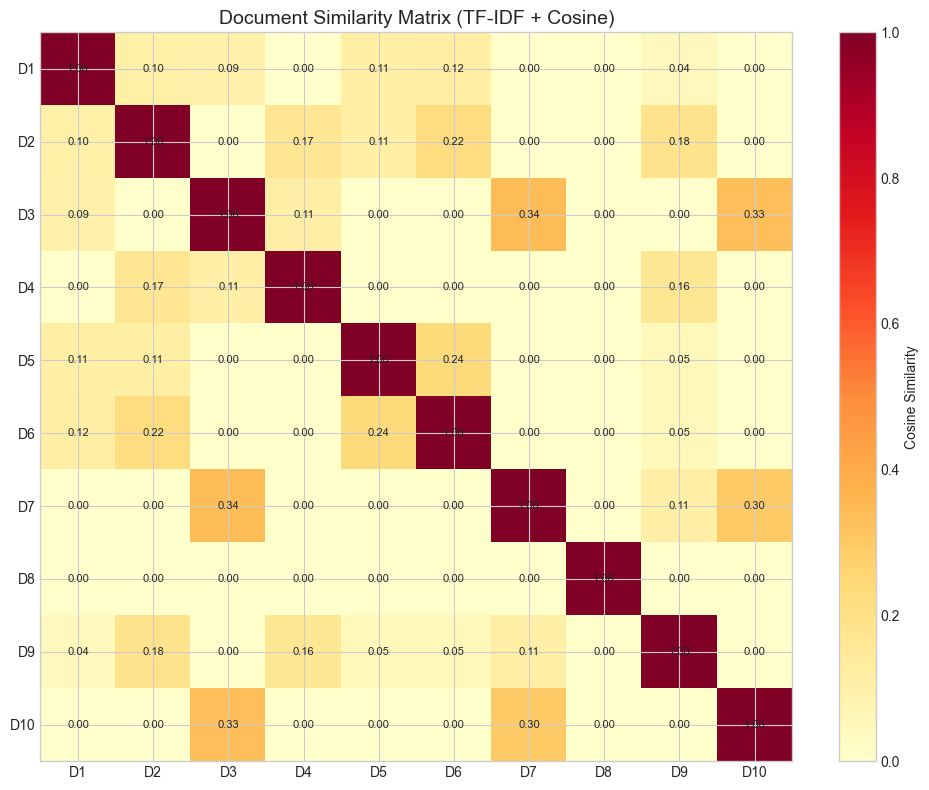

In [46]:
# Visualize similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(sim_matrix, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Cosine Similarity')
plt.xticks(range(len(corpus)), [f"D{i+1}" for i in range(len(corpus))])
plt.yticks(range(len(corpus)), [f"D{i+1}" for i in range(len(corpus))])
plt.title('Document Similarity Matrix (TF-IDF + Cosine)', fontsize=14)

# Insert value into cells
for i in range(len(corpus)):
    for j in range(len(corpus)):
        plt.text(j, i, f'{sim_matrix[i,j]:.2f}', 
                ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

### Analyzing: Find similar documents

In [47]:
def find_most_similar(doc_idx, sim_matrix, doc_titles, top_k=3):
    """Find top-k most similar documents to a given document."""
    similarities = sim_matrix[doc_idx]
    # Exclude itself (similarity = 1.0)
    sorted_indices = similarities.argsort()[::-1][1:top_k+1]
    
    results = []
    for idx in sorted_indices:
        results.append((doc_titles[idx], similarities[idx]))
    return results

# Find most similar documents for each document
print(" Most Similar Documents:")

for i in range(len(corpus)):
    similar = find_most_similar(i, sim_matrix, doc_titles, top_k=2)
    print(f"\n{doc_titles[i]}:")
    for title, score in similar:
        print(f"   {title} (similarity: {score:.3f})")

 Most Similar Documents:

D1: ML Introduction:
   D6: Unsupervised Learning (similarity: 0.115)
   D5: Supervised Learning (similarity: 0.113)

D2: Deep Learning:
   D6: Unsupervised Learning (similarity: 0.219)
   D9: RNN (similarity: 0.185)

D3: NLP Overview:
   D7: Text Classification (similarity: 0.342)
   D10: Transformers (similarity: 0.334)

D4: Neural Networks:
   D2: Deep Learning (similarity: 0.166)
   D9: RNN (similarity: 0.160)

D5: Supervised Learning:
   D6: Unsupervised Learning (similarity: 0.237)
   D1: ML Introduction (similarity: 0.113)

D6: Unsupervised Learning:
   D5: Supervised Learning (similarity: 0.237)
   D2: Deep Learning (similarity: 0.219)

D7: Text Classification:
   D3: NLP Overview (similarity: 0.342)
   D10: Transformers (similarity: 0.301)

D8: Word Embeddings:
   D10: Transformers (similarity: 0.000)
   D9: RNN (similarity: 0.000)

D9: RNN:
   D2: Deep Learning (similarity: 0.185)
   D4: Neural Networks (similarity: 0.160)

D10: Transformers:
   D3: 

## Part 6: Dimensionality Reduction với PCA và SVD

### 6.1 PCA on Dense Vectors

In [48]:
# Using PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
docs_2d_pca = pca.fit_transform(tfidf_norm)

print(f" PCA Results:")
print(f"   Original shape: {tfidf_norm.shape}")
print(f"   Reduced shape: {docs_2d_pca.shape}")
print(f"\n   Variance explained:")
print(f"    PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"    PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"    Total: {sum(pca.explained_variance_ratio_):.2%}")

 PCA Results:
   Original shape: (10, 60)
   Reduced shape: (10, 2)

   Variance explained:
    PC1: 18.64%
    PC2: 13.92%
    Total: 32.55%


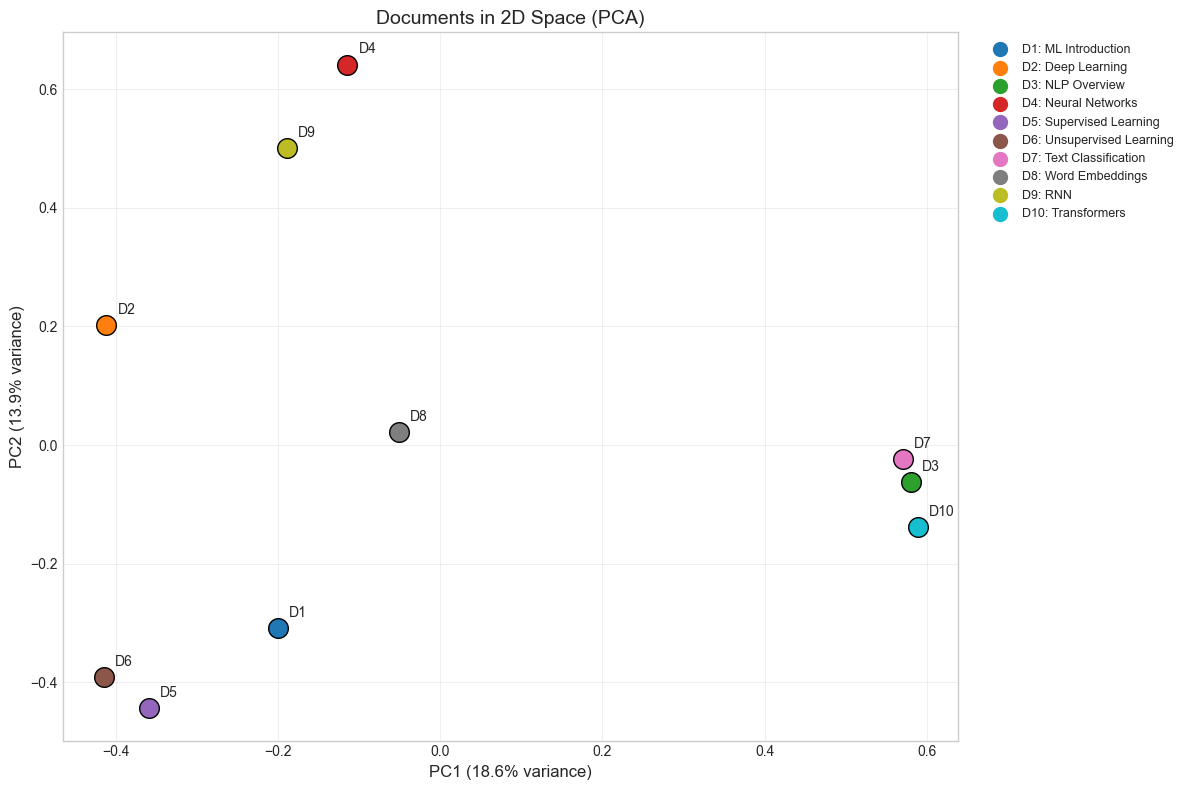

In [49]:
# Visualize documents 
plt.figure(figsize=(12, 8))

# Scatter plot
colors = plt.cm.tab10(np.linspace(0, 1, len(corpus)))
for i, (x, y) in enumerate(docs_2d_pca):
    plt.scatter(x, y, c=[colors[i]], s=200, edgecolors='black', linewidths=1)
    plt.annotate(f'D{i+1}', (x, y), xytext=(8, 8), textcoords='offset points', fontsize=10)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Documents in 2D Space (PCA)', fontsize=14)
plt.grid(True, alpha=0.3)

for i, title in enumerate(doc_titles):
    plt.scatter([], [], c=[colors[i]], label=title, s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

### 6.2 TruncatedSVD cho Sparse Matrices

In [50]:
# TruncatedSVD - suitable for sparse TF-IDF matrices
svd = TruncatedSVD(n_components=2, random_state=42)

# Using sparse matrix from sklearn
tfidf_sparse = vectorizer_norm.fit_transform(corpus)
docs_2d_svd = svd.fit_transform(tfidf_sparse)

print(f" TruncatedSVD Results:")
print(f"   Original shape: {tfidf_sparse.shape}")
print(f"   Reduced shape: {docs_2d_svd.shape}")
print(f"\n   Variance explained:")
print(f"   - Component 1: {svd.explained_variance_ratio_[0]:.2%}")
print(f"   - Component 2: {svd.explained_variance_ratio_[1]:.2%}")
print(f"   - Total: {sum(svd.explained_variance_ratio_):.2%}")

 TruncatedSVD Results:
   Original shape: (10, 60)
   Reduced shape: (10, 2)

   Variance explained:
   - Component 1: 6.74%
   - Component 2: 14.19%
   - Total: 20.92%


###  Exercise 6.1: Find optimal components

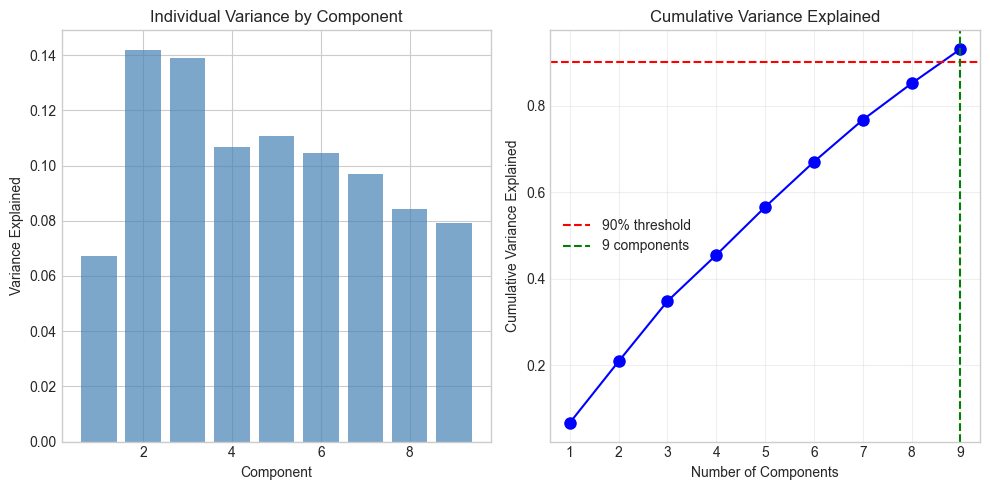


 To achieve 90% variance explained, 9 components are needed
   (Total variance with 9 components: 93.07%)


In [51]:
# Let check on multiple components
max_components = min(tfidf_sparse.shape) - 1
svd_full = TruncatedSVD(n_components=max_components, random_state=42)
svd_full.fit(tfidf_sparse)

# Cumulative variance
cumulative_variance = np.cumsum(svd_full.explained_variance_ratio_)

# Find number of components for 90% variance
n_for_90 = np.argmax(cumulative_variance >= 0.90) + 1

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, max_components + 1), svd_full.explained_variance_ratio_, alpha=0.7, color='steelblue')
plt.xlabel('Component')
plt.ylabel('Variance Explained')
plt.title('Individual Variance by Component')

plt.subplot(1, 2, 2)
plt.plot(range(1, max_components + 1), cumulative_variance, 'b-o', markersize=8)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.axvline(x=n_for_90, color='g', linestyle='--', label=f'{n_for_90} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n To achieve 90% variance explained, {n_for_90} components are needed")
print(f"   (Total variance with {n_for_90} components: {cumulative_variance[n_for_90-1]:.2%})")

## Part 7: Implement document search engine

In [52]:
class SimpleSearchEngine:
    """
    Document search engine using TF-IDF and cosine similarity.
    """
    
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words='english',
            ngram_range=(1, 2),  # Unigrams and Bigrams
            max_df=0.9,
            min_df=1
        )
        self.tfidf_matrix = None
        self.documents = None
        self.doc_titles = None
    
    def fit(self, documents, titles=None):
        """
        Index documents.
        
        Args:
            documents: List of documents
            titles: List of titles
        """
        self.documents = documents
        self.doc_titles = titles if titles else [f"Doc {i+1}" for i in range(len(documents))]
        self.tfidf_matrix = self.vectorizer.fit_transform(documents)
        print(f" Indexed {len(documents)} documents")
        print(f" Vocabulary size: {len(self.vectorizer.get_feature_names_out())}")
    
    def search(self, query, top_k=5):
        """
        Search for documents matching the query.
        
        Args:
            query: Search query
            top_k: Number of results to return
        
        Returns:
            List of (title, document, score)
        """
        # Transform query
        query_vec = self.vectorizer.transform([query])
        
        # Compute similarities
        similarities = cosine_similarity(query_vec, self.tfidf_matrix)[0]
        
        # Get top-k indices
        top_indices = similarities.argsort()[::-1][:top_k]
        
        # Prepare results
        results = []
        for idx in top_indices:
            if similarities[idx] > 0:  # Only return results with similarity > 0
                results.append({
                    'title': self.doc_titles[idx],
                    'document': self.documents[idx],
                    'score': similarities[idx]
                })
        
        return results
    
    def display_results(self, results, query):
        """Display search results nicely."""
        print(f"\n Search Results for: \"{query}\"")
        
        if not results:
            print("   No relevant documents found.")
            return
        
        for i, result in enumerate(results, 1):
            print(f"\n [{i}] {result['title']}")
            print(f"   Score: {result['score']:.4f}")
            print(f"   Content: {result['document'][:100]}...")

In [53]:
# Initialize and index
search_engine = SimpleSearchEngine()
search_engine.fit(corpus, doc_titles)

 Indexed 10 documents
 Vocabulary size: 126


In [54]:
# Let check the search engine
queries = [
    "neural network deep learning",
    "natural language processing text",
    "supervised machine learning data",
    "transformer attention mechanism"
]

for query in queries:
    results = search_engine.search(query, top_k=3)
    search_engine.display_results(results, query)
    print()


 Search Results for: "neural network deep learning"

 [1] D2: Deep Learning
   Score: 0.4337
   Content: Deep learning uses neural networks with many layers to model complex patterns in data....

 [2] D4: Neural Networks
   Score: 0.0948
   Content: Neural networks are inspired by the biological structure of the human brain....

 [3] D9: RNN
   Score: 0.0782
   Content: Recurrent neural networks are designed for sequential data like text and time series....


 Search Results for: "natural language processing text"

 [1] D7: Text Classification
   Score: 0.5767
   Content: Text classification is a common natural language processing task....

 [2] D3: NLP Overview
   Score: 0.4608
   Content: Natural language processing helps computers understand and generate human language....

 [3] D10: Transformers
   Score: 0.4513
   Content: Transformers have revolutionized natural language processing with attention mechanisms....


 Search Results for: "supervised machine learning data"

 [1] D1: 

## Part 8: Word Similarity

In [55]:
def find_similar_words(target_word, cooc_matrix, vocab, top_k=5):
    """
    Find the most similar words to a given target word. 
    Args:
        target_word: Word to find
        cooc_matrix: Co-occurrence matrix
        vocab: Vocabulary list
        top_k: Number of similar words to find
    
    Returns:
        List of (word, similarity_score)
    """
    if target_word not in vocab:
        return []
    
    word_to_idx = {w: i for i, w in enumerate(vocab)}
    target_idx = word_to_idx[target_word]
    target_vec = cooc_matrix[target_idx]
    
    # Calculate similarity with all words
    similarities = []
    for i, word in enumerate(vocab):
        if i != target_idx:
            sim = cosine_similarity_manual(target_vec, cooc_matrix[i])
            similarities.append((word, sim))
    
    # Sort and get top-k
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

# Test with some words
test_words = ['learning', 'neural', 'data', 'language']

print(" Word Similarity (based on co-occurrence):")

for word in test_words:
    if word in vocabulary:
        similar = find_similar_words(word, cooc_matrix, vocabulary, top_k=3)
        print(f"\n'{word}' → ", end="")
        for w, score in similar:
            print(f"{w}({score:.3f}) ", end="")

 Word Similarity (based on co-occurrence):

'learning' → finds(0.289) intelligence(0.289) requires(0.289) 
'neural' → recurrent(0.548) biological(0.516) layers(0.516) 
'data' → examples(0.474) without(0.447) finds(0.335) 
'language' → mechanisms(0.566) transformers(0.566) processing(0.500) 